# Image augmentation techniques using Tensorflow

The motivation behind data/image augmentation is achieve have good diversity over out data set to allow our network to generalize well during the testing (or deployment) phase

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import cv2 
import math

%matplotlib inline

## Collect image file paths

In [2]:
def get_image_paths():
    folder = './raw_images'
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder, f) for f in files]
    return files

In [3]:
X_img_file_paths = get_image_paths()
print(X_img_file_paths)

['./raw_images/01.png', './raw_images/02.png', './raw_images/03.png', './raw_images/04.png', './raw_images/05.png', './raw_images/06.png', './raw_images/07.png', './raw_images/08.png', './raw_images/09.png', './raw_images/10.png', './raw_images/11.png', './raw_images/12.png']


## Resize images to a common size

In [4]:
# Resizing
IMAGE_SIZE = 224

def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[None, None, 3])
    tf_img = tf.image.resize_images(X, [IMAGE_SIZE, IMAGE_SIZE],
                             tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:,:,:3]
            resized_img = session.run(tf_img, feed_dict={X: img})
            X_data.append(resized_img)
        
        X_data = np.array(X_data, dtype=np.float32)
        return X_data

In [5]:
X_imgs = tf_resize_images(X_img_file_paths)
print(X_imgs.shape)

(12, 224, 224, 3)


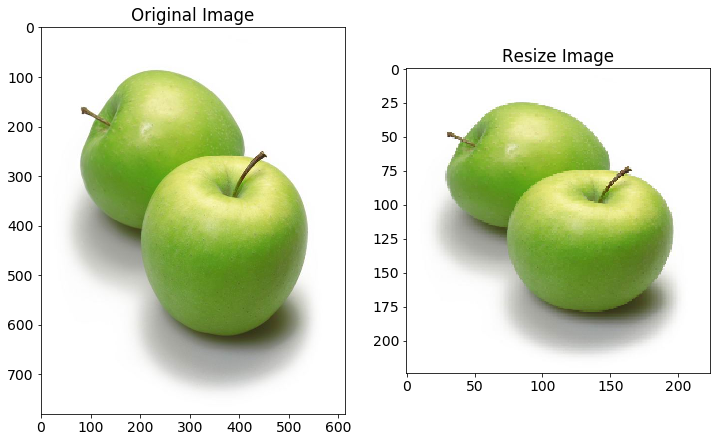

In [6]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(12, 12))
plt.subplot(121) # numrows, numcols, subplotnum
plt.imshow(mpimg.imread(X_img_file_paths[0]))
plt.title('Original Image')
plt.subplot(122)
plt.imshow(X_imgs[0])
plt.title('Resize Image')
plt.show()

## Display all images

In [7]:
def display_all_images(X_imgs, n_cols=4):
    n_rows = math.ceil(len(X_imgs) / n_cols)
    fig, ax = plt.subplots(figsize=(3*n_rows, 3*n_cols))
    for index, X_img in enumerate(X_imgs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_img)
        plt.axis('off')
        
    plt.show()

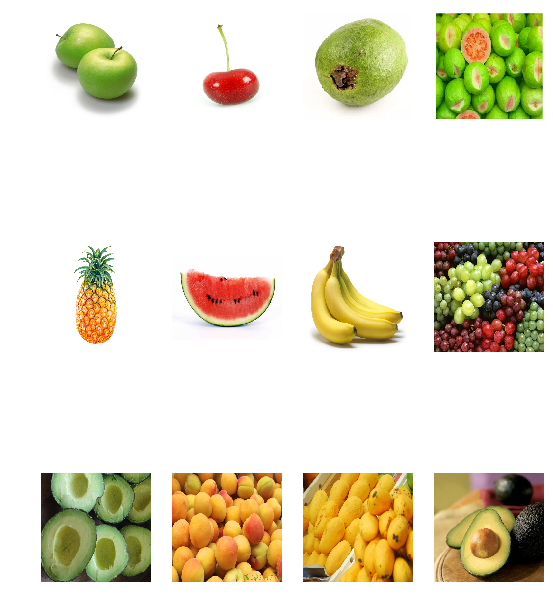

In [8]:
display_all_images(X_imgs)

## Image Augmentation Techniques

### 1) Scaling
Extracts crops from the input image tensor and bilinearly resizes them (possibly with aspect ratio change) to a common output size specified by 'crop_size'

In [9]:
def centrally_scale_images(X_imgs, scales):
    # Calculating tf.image.crop_and_resize() params
    boxes = np.zeros([len(scales), 4], dtype=np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype=np.float32)

    box_ind = np.zeros(len(scales), dtype=np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype=np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[1, IMAGE_SIZE, IMAGE_SIZE, 3])
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    
    with tf.Session() as session:
        for img in X_imgs:
            batch_img = np.expand_dims(img, axis=0)
            scaled_imgs = session.run(tf_img, feed_dict={X: batch_img})
            X_scale_data.extend(scaled_imgs)
        
        X_scale_data = np.array(X_scale_data, dtype=np.float32)
        return X_scale_data

In [10]:
scales = [0.90, 0.75, 0.60]
scaled_imgs = centrally_scale_images(X_imgs, scales)
print(scaled_imgs.shape)

(36, 224, 224, 3)


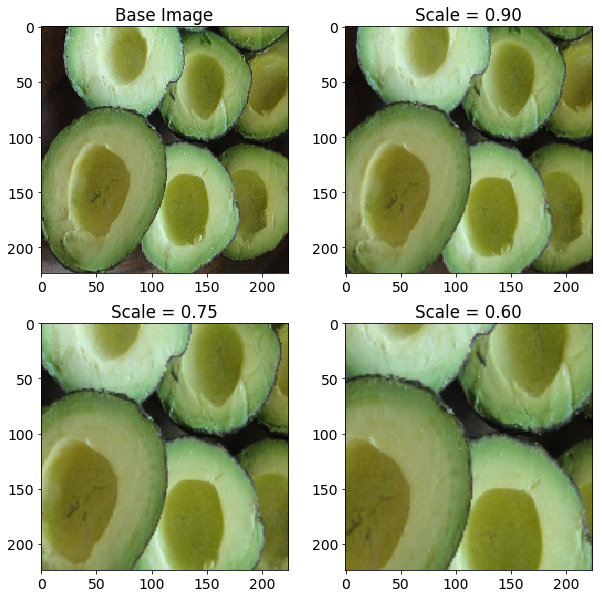

In [11]:
# Visualising the scaled images
index = np.random.randint(0, len(X_imgs))
fig, ax = plt.subplots(figsize=(10, 10))
n_scales = len(scales)

plt.subplot(221)
plt.imshow(X_imgs[index])
plt.title('Base Image')

plt.subplot(222)
plt.imshow(scaled_imgs[n_scales*index])
plt.title('Scale = 0.90')

plt.subplot(223)
plt.imshow(scaled_imgs[n_scales*index + 1])
plt.title('Scale = 0.75')

plt.subplot(224)
plt.imshow(scaled_imgs[n_scales*index + 2])
plt.title('Scale = 0.60')

plt.show()

### 2) Translation

In [12]:
def get_translate_params(index): 
    if index == 0: # Translate left 20%
        offset = np.array([0.0, 0.2], dtype=np.float32)
        size = np.array([IMAGE_SIZE, math.ceil(0.8 * IMAGE_SIZE)], dtype=np.float32)
        w_start = 0
        w_end = int(math.ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20%
        offset = np.array([0.0, -0.2], dtype=np.float32)
        size = np.array([IMAGE_SIZE, math.ceil(0.8 * IMAGE_SIZE)], dtype=np.float32)
        w_start = int(math.floor(0.2 * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20%
        offset = np.array([0.2, 0.0], dtype=np.float32)
        size = np.array([math.ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype=np.float32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(math.ceil(0.8 * IMAGE_SIZE))    
    elif index == 3: # Translate bottom 20%
        offset = np.array([-0.2, 0.0], dtype=np.float32)
        size = np.array([math.ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype=np.float32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(math.floor(0.2 * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros([len(X_imgs), 2], dtype=np.float32)
    n_translations = 4
    X_translated_data = []

    tf.reset_default_graph()
    with tf.Session() as session:
        for i in range(n_translations):
            X_translated =\
                np.ones([len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3], dtype=np.float32)
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_params(i)
            offsets[:,:] = base_offset
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            glimpses = session.run(glimpses)
            
            X_translated[:, h_start:h_end, w_start:w_end, :] = glimpses
            X_translated_data.extend(X_translated)
     
    X_translated_data = np.array(X_translated_data, dtype=np.float32)
    return X_translated_data

In [13]:
translated_imgs = translate_images(X_imgs)
print(translated_imgs.shape)

(48, 224, 224, 3)


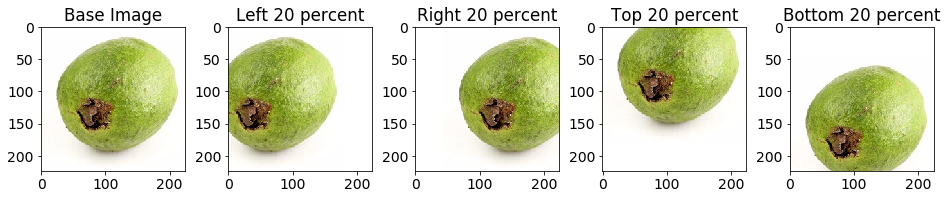

In [14]:
# Visualise the Translated images

gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

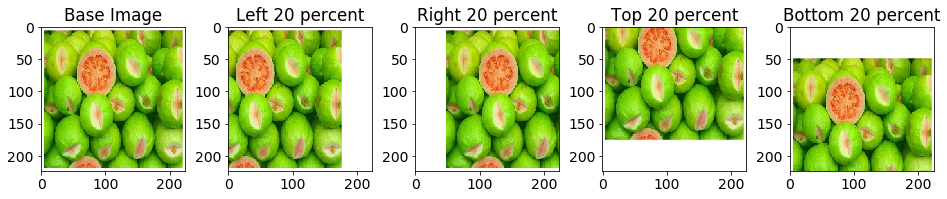

In [15]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[3])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[3])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[15])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[27])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[39])
plt.title('Bottom 20 percent')
plt.show()

### 3) Rotation (90 degrees)

In [16]:
def rotate_images(X_imgs):
    X_rotate_data = []
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k) # Rotating images by 90, 180 and 270 degrees

    with tf.Session() as session:
        for img in X_imgs:
            for i in range(3):
                rotated_img = session.run(tf_img, feed_dict={X: img, k:i+1})
                X_rotate_data.append(rotated_img)
    
    X_rotate_data = np.array(X_rotate_data, dtype=np.float32)
    return X_rotate_data

In [17]:
rotated_imgs = rotate_images(X_imgs)
print(rotated_imgs.shape)

(36, 224, 224, 3)


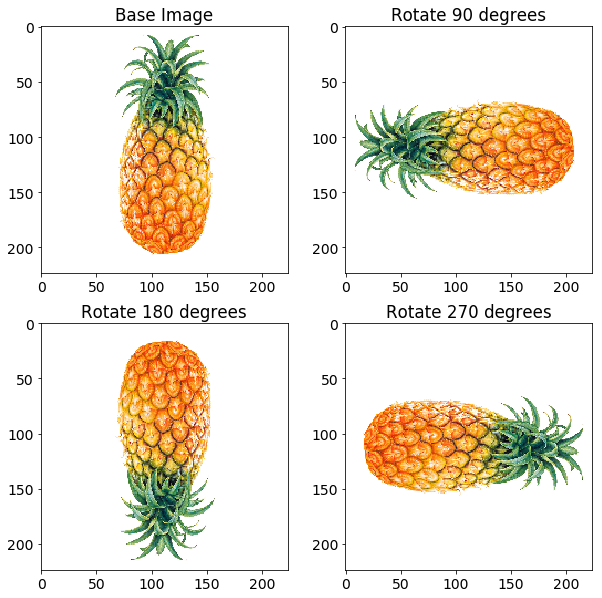

In [18]:
# Visualising rotated images

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[4])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[12])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[13])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[14])
plt.title('Rotate 270 degrees')
plt.show()

### 4) Rotation (at finer angles)

Depending upon the requirement, there maybe a necessity to orient the object at minute angles. However problem with this approach is, it will add background noise. If the background in image is of a fixed color (say white or black), the newly added background can blend with the image. **However, if the newly added background color doesn’t blend, the network may consider it as to be a feature and learn unnecessary features.**

In [19]:
def finer_rotate_images(X_imgs, start, end, n_images):
    tf.reset_default_graph()
    
    X_rotate_data = []
    X = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, 3])
    radian = tf.placeholder(tf.float32, shape=[len(X_imgs)])
    tf_img = tf.contrib.image.rotate(X, radian)
    
    step = (end - start) / (n_images - 1)
    
    with tf.Session() as session:
        for index in range(n_images):
            degree = start + index * step
            radian_val = degree * np.pi / 180
            radian_arr = [radian_val] * len(X_imgs)
            rotated_imgs = session.run(tf_img, feed_dict={
                X: X_imgs, radian: radian_arr
            })
            X_rotate_data.extend(rotated_imgs)

    X_rotate_data = np.array(X_rotate_data, dtype=np.float32)
    return X_rotate_data

In [20]:
finer_rotated_imgs = finer_rotate_images(X_imgs, -90, 90, 14)
print(finer_rotated_imgs.shape)

(168, 224, 224, 3)


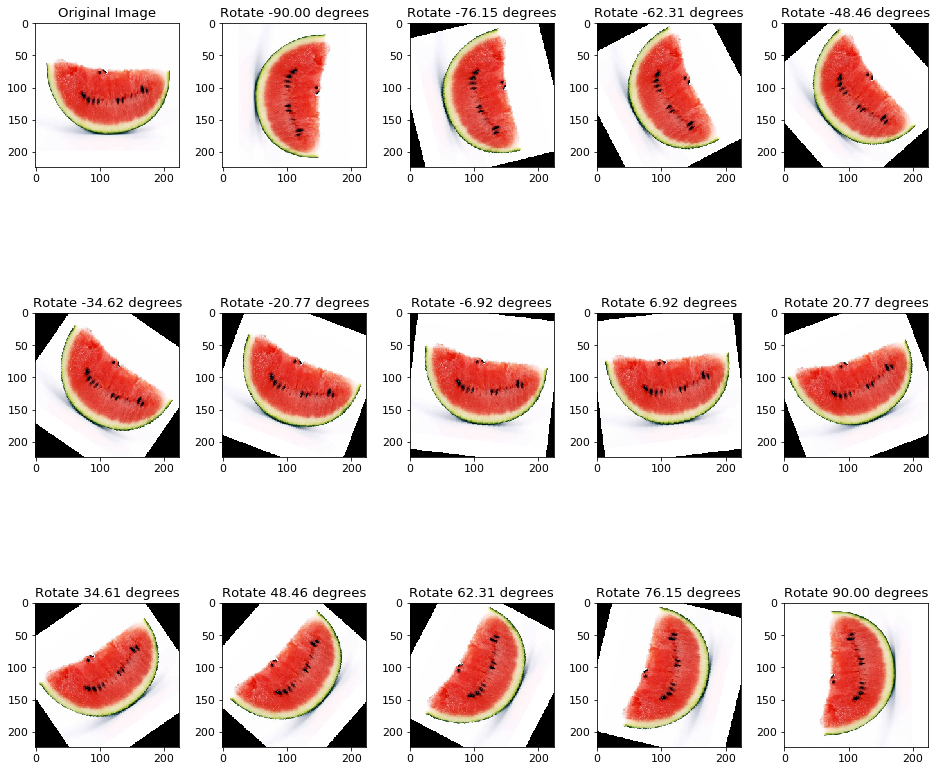

In [21]:
# Visualising the finer rotated images
matplotlib.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize=(16, 16))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace=0.30, hspace=0.0002)

plt.subplot(gs[0])
plt.imshow(X_imgs[5])
plt.title('Original Image')

for i in range(14):
    plt.subplot(gs[i + 1])
    plt.imshow(finer_rotated_imgs[5 + 12*i])
    plt.title('Rotate {:.2f} degrees'.format(-90 + 13.846*i))

plt.show()

### 5) Flipping

Flipping is **important** for network to remove its bias of assuming certain features of the object are available on only a particular side. Consider the case shown in the example below. You don’t want the network to learn that the *tilt* of banana happens only on the right side as observed in the base image. 

In [22]:
def flip_images(X_imgs):
    tf.reset_default_graph()
    X_flip_data = []
    X = tf.placeholder(tf.float32, shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    
    with tf.Session() as session:
        for img in X_imgs:
            flipped_imgs = session.run([tf_img1, tf_img2, tf_img3]
                                       , feed_dict={X: img})
            X_flip_data.extend(flipped_imgs)
    
    X_flip_data = np.array(X_flip_data, dtype=np.float32)
    return X_flip_data

In [23]:
flipped_imgs = flip_images(X_imgs)
print(flipped_imgs.shape)

(36, 224, 224, 3)


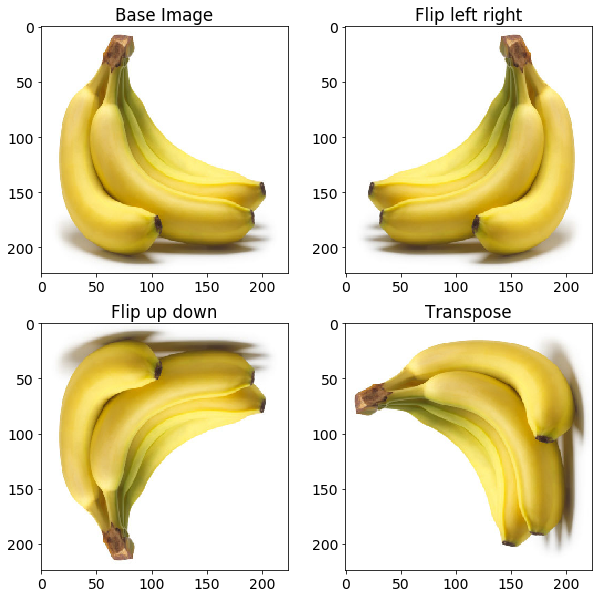

In [24]:
# Visualising the flipped images
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[6])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(flipped_imgs[18])
plt.title('Flip left right')
plt.subplot(2, 2, 3)
plt.imshow(flipped_imgs[19])
plt.title('Flip up down')
plt.subplot(2, 2, 4)
plt.imshow(flipped_imgs[20])
plt.title('Transpose')
plt.show()

### 6) Salt & Pepper Noise

In [25]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

In [26]:
salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs)
print(salt_pepper_noise_imgs.shape)

(12, 224, 224, 3)


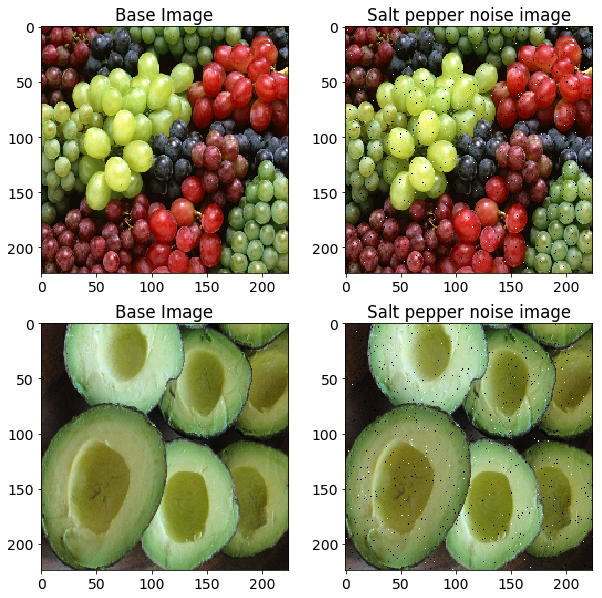

In [27]:
# Visualising the salt and pepper noise in images

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[7])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_noise_imgs[7])
plt.title('Salt pepper noise image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[8])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(salt_pepper_noise_imgs[8])
plt.title('Salt pepper noise image')
plt.show()

### 7) Lighting Conditions

This is a very important type of diversity needed in the image dataset not only for the network to learn properly the object of interest but also to simulate the practical scenario of images being taken by the user. The lighting condition of the images are varied by adding Gaussian noise in the image.

In [28]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    
    # Gaussian distribution params
    mean = 0.0; var = 0.1; std = var ** 0.5
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)

    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)

    return gaussian_noise_imgs

In [29]:
gaussian_noise_imgs = add_gaussian_noise(X_imgs)
print(gaussian_noise_imgs.shape)

(12, 224, 224, 3)


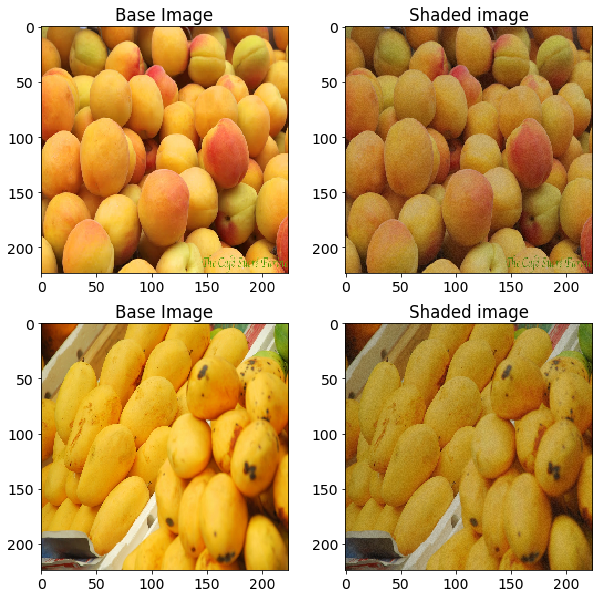

In [30]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[9])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gaussian_noise_imgs[9])
plt.title('Shaded image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[10])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(gaussian_noise_imgs[10])
plt.title('Shaded image')
plt.show()

### 8) Perspective Transform

In perspective transform, we try to project image from a different point of view. For this, the position of object should be known in advance. Merely calculating perspective transform without knowing the position of the object can lead to *degradation* of the dataset. Hence, this type of augmentation has to be performed selectively. The greatest advantage with this augmentation is that it can emphasize on parts of object in image which the network needs to learn.

In [36]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrix(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Performing perspective transform for selective images
    perspective_matrix = get_perspective_matrix(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                    (X_img.shape[0], X_img.shape[1]),
                                flags=cv2.INTER_LINEAR)
    
    return warped_img

In [37]:
X_img = X_imgs[11]
perspective_img = perspective_transform(X_img)
print(perspective_img.shape)

(224, 224, 3)


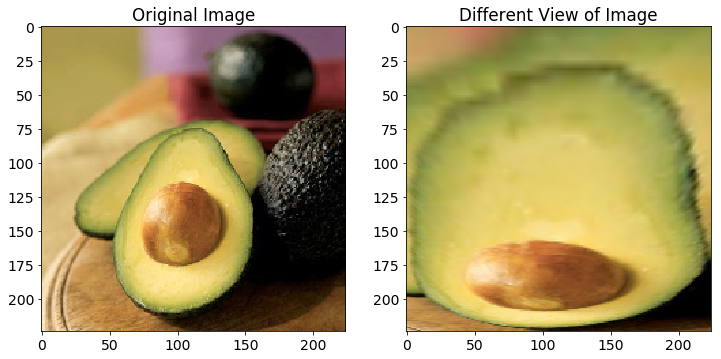

In [38]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_imgs[11])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_img)
plt.title('Different View of Image')
plt.show()